<a href="https://colab.research.google.com/github/Arpitkamal/Deep-Learning---Deep-Convolutional-Neural-Networks/blob/master/CNNVisualisation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Outline



1.   Using torchvision.datasets with a custom folder of images
2.   Occlusion analysis with pretrained model
3.   Filter visualisation with pretrained model



In [3]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torchvision
import torchvision.datasets as datasets
import torchvision.models as models
import torchvision.transforms as transforms


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Load dataset

In [ ]:
!unzip data.zip

In [6]:
with open("data/imagenet_labels.txt") as f:
  classes = eval(f.read())

In [7]:
print(classes)

{0: 'tench, Tinca tinca', 1: 'goldfish, Carassius auratus', 2: 'great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias', 3: 'tiger shark, Galeocerdo cuvieri', 4: 'hammerhead, hammerhead shark', 5: 'electric ray, crampfish, numbfish, torpedo', 6: 'stingray', 7: 'cock', 8: 'hen', 9: 'ostrich, Struthio camelus', 10: 'brambling, Fringilla montifringilla', 11: 'goldfinch, Carduelis carduelis', 12: 'house finch, linnet, Carpodacus mexicanus', 13: 'junco, snowbird', 14: 'indigo bunting, indigo finch, indigo bird, Passerina cyanea', 15: 'robin, American robin, Turdus migratorius', 16: 'bulbul', 17: 'jay', 18: 'magpie', 19: 'chickadee', 20: 'water ouzel, dipper', 21: 'kite', 22: 'bald eagle, American eagle, Haliaeetus leucocephalus', 23: 'vulture', 24: 'great grey owl, great gray owl, Strix nebulosa', 25: 'European fire salamander, Salamandra salamandra', 26: 'common newt, Triturus vulgaris', 27: 'eft', 28: 'spotted salamander, Ambystoma maculatum', 29: 'axolotl, mu

In [8]:
transform = transforms.Compose([
       transforms.Resize(224),
       transforms.ToTensor(),
       transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

In [9]:
evelset = torchvision.datasets.ImageFolder(root='./data/imagenet', transform=transform)

In [10]:
batch_size = 1

In [11]:
evalloader = torch.utils.data.DataLoader(evelset, batch_size=batch_size, shuffle=True)

In [12]:
dataiter = iter(evalloader)
images,labels = dataiter.next()

print(images.shape)
print(images[0].shape)
print(labels[0].item())

torch.Size([1, 3, 224, 224])
torch.Size([3, 224, 224])
0


# Load pretrained model 

In [13]:
model = models.vgg16(pretrained=True)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/checkpoints/vgg16-397923af.pth


In [14]:
model.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

# Visualise image

In [20]:
def imshow(img, title):

  std_correction = np.asarray([0.229, 0.224, 0.225]).reshape(3, 1, 1)
  mean_correction = np.asarray([0.485, 0.456, 0.406]).reshape(3, 1, 1)
  npimg = np.multiply(img.numpy(), std_correction) + mean_correction

  plt.figure(figsize=(batch_size * 4, 4))
  plt.axis('off')
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.title(title)
  plt.show()

In [21]:
def show_batch_images(dataloader):
  images,_ = next(iter(dataloader))

  outputs = model(images)
  _, pred = torch.max(outputs.data, 1)

  img = torchvision.utils.make_grid(images)
  imshow(img, title=[classes[x.item()] for x in pred ])

  return images, pred

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


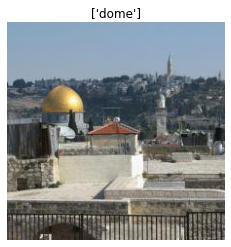

In [38]:
images, pred = show_batch_images(evalloader)

# Occlusion analysis

In [39]:
outputs = model(images)
print(outputs.shape)
outputs = nn.functional.softmax(outputs, dim=1)
prob_no_occ, pred = torch.max(outputs.data, 1)
prob_no_occ = prob_no_occ[0].item()
print(prob_no_occ)

torch.Size([1, 1000])
0.7955080270767212


In [40]:
def occlusion(model, image, label, occ_size=50, occ_stride=50, occ_pixel=0.5):
    
    width, height = image.shape[-2], image.shape[-1]
    
    output_height = int(np.ceil((height-occ_size)/occ_stride))  #width and height of the output
    output_width = int(np.ceil((width-occ_size)/occ_stride))
    
    heatmap = torch.zeros((output_height, output_width))
    
    for h in range(0, height):
        for w in range(0, width):
            
            h_start = h*occ_stride
            w_start = w*occ_stride
            h_end = min(height, h_start + occ_size)
            w_end = min(width, w_start + occ_size)
            
            if (w_end) >= width or (h_end) >= height:
                continue
            
            input_image = image.clone().detach()          #deep copy
            input_image[:, :, w_start:w_end, h_start:h_end] = occ_pixel
            
            output = model(input_image)
            output = nn.functional.softmax(output, dim=1)
            prob = output.tolist()[0][label]
            
            heatmap[h, w] = prob 

    return heatmap

In [41]:
heatmap = occlusion(model, images, pred[0].item(), 32, 14)

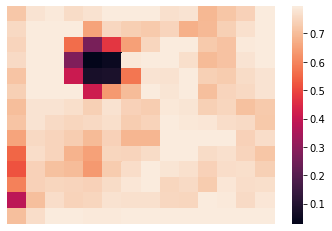

In [42]:
imgplot = sns.heatmap(heatmap, xticklabels=False, yticklabels=False, vmax=prob_no_occ)